In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from models.linear_regression import LinearRegressionX
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

In [68]:
data = pd.read_csv("data/turbo-az-cars-cleaned.csv")

In [69]:
data

,Car Name,Liters,Age,Distance,Price
0,Mercedes E 240,2.4,28,400000.0,10900.0
1,Toyota Camry,2.5,3,75000.0,47430.0
2,BMW X5,3.0,6,69500.0,107100.0
3,Nissan Tiida,1.5,14,143922.0,12900.0
4,Chevrolet Trax,1.4,6,67000.0,17900.0
...,...,...,...,...,...
345,Hyundai Santa Fe,2.4,12,124000.0,27000.0
346,Hyundai Elantra,2.0,9,97000.0,18500.0
347,Fiat Doblo,1.4,3,37379.0,30000.0
348,Volkswagen Touareg,3.2,22,185554.0,11000.0


In [70]:
data.describe()

,Liters,Age,Distance,Price
count,350.000000,350.000000,3.500000e+02,350.000000
mean,2.540000,10.111429,1.672393e+05,42638.589714
std,1.623326,6.152003,1.695674e+05,41193.835475
min,1.200000,0.000000,0.000000e+00,4600.000000
25%,1.700000,6.000000,7.500000e+04,19775.000000
50%,2.000000,10.000000,1.350000e+05,29949.500000
75%,3.000000,13.000000,2.155038e+05,50620.000000
max,13.000000,36.000000,1.370000e+06,365500.000000


In [71]:
X = data[['Liters', 'Age', 'Distance']]
Y = data['Price']

<Figure size 2000x4000 with 0 Axes>

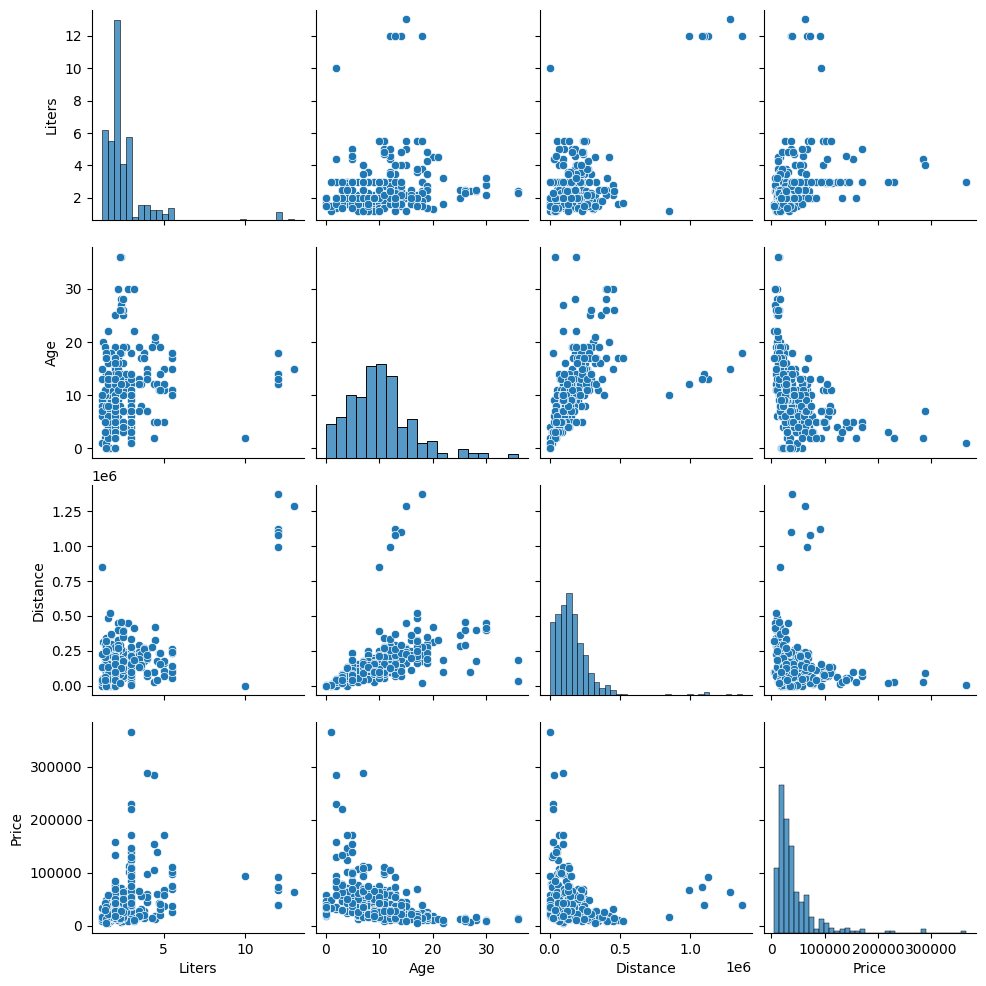

In [72]:
plt.figure(figsize=(20, 40))
sns.pairplot(data=data)
plt.show()

In [73]:
os.makedirs('results', exist_ok=True)

In [74]:
def model_build(degree=2):
    return make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree),
        LinearRegressionX()
    )

In [75]:
def train_and_select_model(X, Y, max_iter=300, degree=2, threshold=0.05):
    best_model = None
    best_diff = float("inf")

    for i in range(max_iter):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
        model = model_build(degree)
        model.fit(X_train, Y_train)

        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        mse_train = mean_squared_error(Y_train, Y_train_pred)
        mse_test = mean_squared_error(Y_test, Y_test_pred)

        diff = abs(mse_train - mse_test) / mse_test

        if diff < threshold:
            best_model = model
            print(f"Stopping early at iteration {i}, MSE train: {mse_train:.2f}, test: {mse_test:.2f}")
            return model, X_train, X_test, Y_train, Y_test
        
        if diff < best_diff:
            best_diff = diff
            best_model = model
            best_data = (X_train, X_test, Y_train, Y_test)
        
    print(f"Best model selected with MSE diff: {best_diff:.4f}")
    return best_model, *best_data
    


In [76]:
model, X_train, X_test, Y_train, Y_test = train_and_select_model(X, Y)

Stopping early at iteration 38, MSE train: 630646231.14, test: 627178070.27


In [77]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [78]:
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

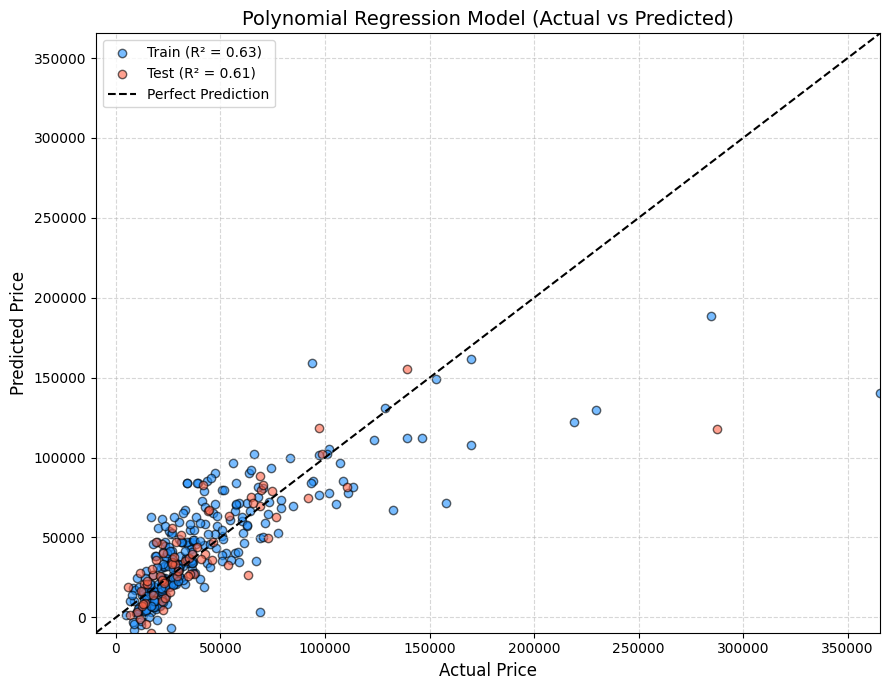

In [80]:
plt.figure(figsize=(9, 7))
plt.scatter(Y_train, Y_train_pred, color='dodgerblue', label=f'Train (R² = {r2_train:.2f})', alpha=0.6, edgecolors='k')
plt.scatter(Y_test, Y_test_pred, color='tomato', label=f'Test (R² = {r2_test:.2f})', alpha=0.6, edgecolors='k')
min_val = min(Y.min(), Y_train_pred.min(), Y_test_pred.min())
max_val = max(Y.max(), Y_train_pred.max(), Y_test_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, label='Perfect Prediction')
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Polynomial Regression Model (Actual vs Predicted)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.savefig("results/prediction_vs_actual.png", dpi=300)
plt.show()

In [81]:
joblib.dump(model, "results/best_polynomial_model.pkl")

['results/best_polynomial_model.pkl']